In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


In [5]:
from voxel_diffusion import VoxelConfig, create_model_and_trainer, create_dataloaders

config = VoxelConfig(
    use_rgb=False,  # or False for occupancy only
    default_color=[0.5, 0.5, 0.5],
    alpha_weight=1.0,
    rgb_weight=1.0
)

print(config.in_channels) # Should be 1

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

1


In [16]:
# Create model with the given config
trainer, model = create_model_and_trainer(
    config=config,
    resolution=32,
    device=device
)

Total parameters: 120096449


In [17]:
train_loader, test_loader = create_dataloaders(
    voxel_dir="objaverse_data_voxelized",
    annotation_file="objaverse_data/annotations.json",
    config=config,
    batch_size=2
)

Finding voxel files: 198044it [01:15, 2630.23it/s]


Found 198044 files (including augmentations)


In [ ]:
# Train model
losses, test_losses = trainer.train(
    train_loader,
    test_loader,
    total_steps=95_000, # This is how many files I have: 198044 around 200k but batch is 2 -> 100k 5% batch -> 95k and 5k test set (this is floor values)
    save_every=5_000,
    eval_every=10_000,
    save_dir='runs/experiment_4'
)

Training:   0%|  | 38/95000 [00:36<24:47:50,  1.06it/s, loss=0.1639, lr=0.000100]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
steps = list(range(0, len(test_losses) * 20_000, 20_000))
plt.plot(steps, test_losses)
plt.title('Test Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

Sampling Steps: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.94it/s]


(2, 1, 32, 32, 32)


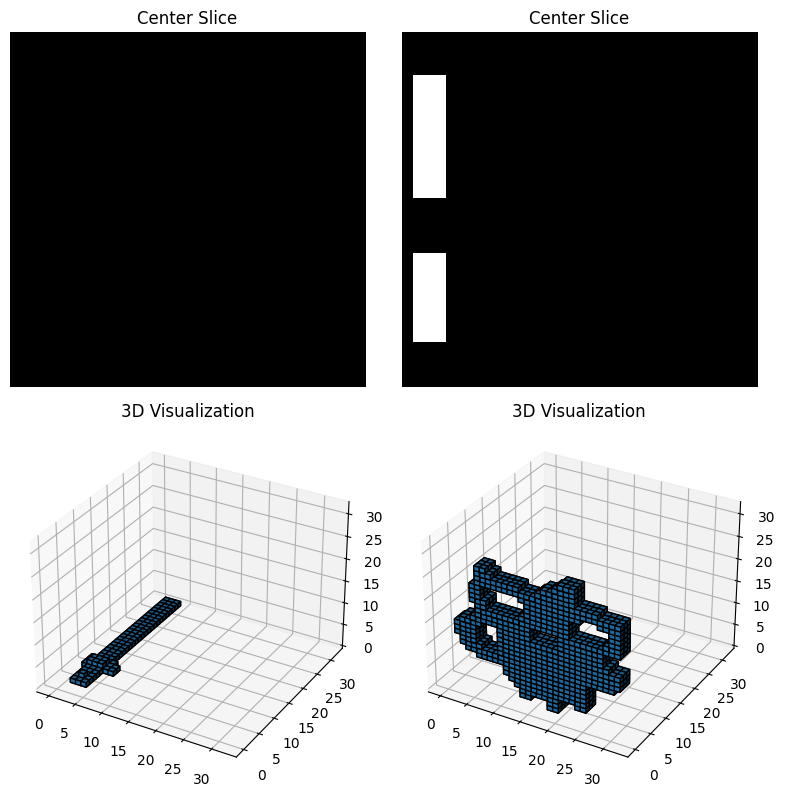

In [6]:
from inference import DiffusionInference3D
from diffusers import DDIMScheduler


diffusion_model = DiffusionModel3D(model, num_timesteps=1000)

diffusion_model.load_state_dict(torch.load("./best_model.pth"))

diffusion_model.to(device)

# noise_scheduler = DDIMScheduler.from_config(diffusion_model.noise_scheduler.config, timestep_spacing="trailing")

# inference = DiffusionInference3D(diffusion_model, noise_scheduler, device=device)
# samples = inference.sample_ddim(num_samples=2, image_size=(32, 32, 32), num_inference_steps = 200, intermediate_visualisation=True)


inference = DiffusionInference3D(diffusion_model, diffusion_model.noise_scheduler, device=device)
samples = inference.sample(num_samples=2, image_size=(32, 32, 32), show_intermediate=False)

inference.visualize_samples(samples, threshold=0.5)


In [4]:
from diffusers import UNet3DConditionModel

model = UNet3DConditionModel(
        sample_size=32,
        in_channels=1,
        out_channels=1,
        layers_per_block=2,
        block_out_channels=(64, 128, 256, 512),
        down_block_types=(
            "CrossAttnDownBlock3D",
            "CrossAttnDownBlock3D",
            "CrossAttnDownBlock3D",
            "DownBlock3D",
        ),
        up_block_types=(
            "UpBlock3D",
            "CrossAttnUpBlock3D",
            "CrossAttnUpBlock3D",
            "CrossAttnUpBlock3D",
        ),
        cross_attention_dim=512,
    )

In [19]:
from diffusion import DiffusionModel3D
from inference import DiffusionInference3D


diffusion_model = DiffusionModel3D(model, num_timesteps=1000)
diffusion_model.load_state_dict(torch.load('runs/experiment_4/models/model_step_20000.pth'))

diffusion_model.to(device)

inferencer = DiffusionInference3D(
    model=diffusion_model,
    noise_scheduler=diffusion_model.noise_scheduler,
    config=config,
    device=device
)

samples = inferencer.sample("a 3D model of a knife", num_samples=2, image_size=(32, 32, 32), show_intermediate=False)

Sampling Steps: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:13<00:00,  3.95it/s]


In [20]:
print(samples.shape)

torch.Size([2, 1, 32, 32, 32])


In [21]:
print(samples[1:2].min())

tensor(-0.0608, device='cuda:0')


In [22]:
print(samples[1:2].max())

tensor(0.8463, device='cuda:0')


(2, 1, 32, 32, 32)


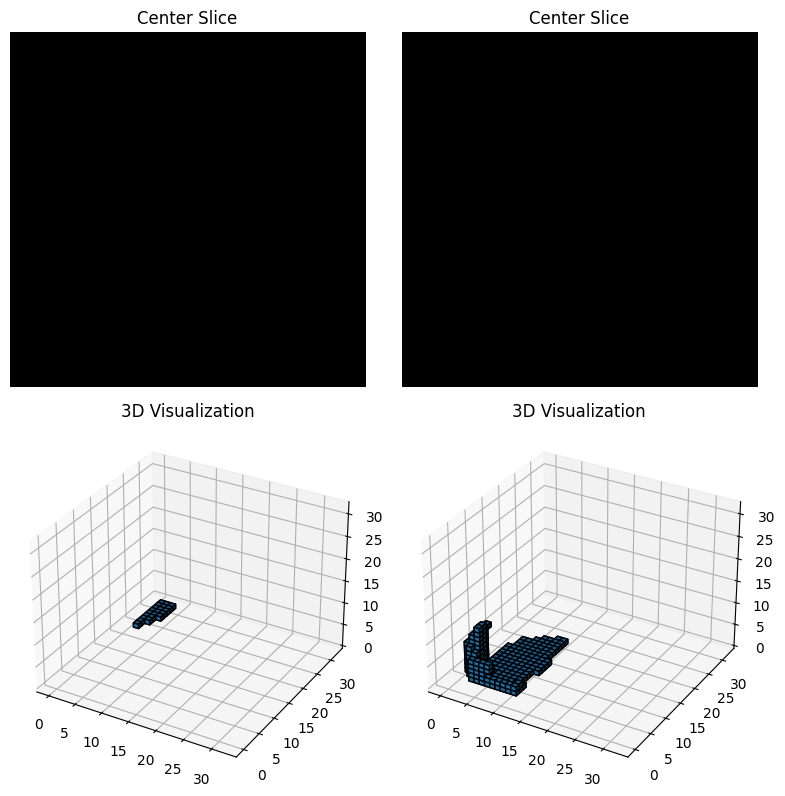

In [23]:
inferencer.visualize_samples(samples)

In [ ]:
from train import main

main()

Finding voxel files: 44it [00:00, 42680.24it/s]



Found 44 files (including augmentations)
Total parameters: 120096449


Training:   0%|          | 0/100000 [00:00<?, ?it/s]/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/PeterAM/miniconda3/envs/stats/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: Fu

In [36]:
from diffusion import DiffusionModel3D, DiffusionConfig
from inference import DiffusionInference3D
from diffusers import UNet3DConditionModel
from voxel_diffusion import VoxelConfig

# Define the model architecture
model = UNet3DConditionModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "CrossAttnDownBlock3D",
        "CrossAttnDownBlock3D",
        "CrossAttnDownBlock3D",
        "DownBlock3D",
    ),
    up_block_types=(
        "UpBlock3D",
        "CrossAttnUpBlock3D",
        "CrossAttnUpBlock3D",
        "CrossAttnUpBlock3D",
    ),
    cross_attention_dim=512,
)

# Define the Diffusion Config (must match training config)
config = DiffusionConfig(
    num_timesteps=1000,
    use_ema=True,  # Enable EMA
    ema_decay=0.9999,
    ema_update_after_step=0,
    ema_device="cpu"
)

voxel_config = VoxelConfig(
        use_rgb=False,  # Set to True if using RGBA data
        default_color=[0.5, 0.5, 0.5],
        alpha_weight=1.0,
        rgb_weight=1.0
    )

# Create Diffusion Model with EMA
diffusion_model = DiffusionModel3D(model=model, config=config)

# Load EMA weights
ema_path = "runs/experiment_5/best_model/best_model"
diffusion_model.load_pretrained(ema_path, load_ema=True)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
diffusion_model.to(device)

# Create the inference pipeline
inferencer = DiffusionInference3D(
    model=diffusion_model,
    noise_scheduler=diffusion_model.noise_scheduler,
    config=voxel_config,
    device=device
)

# Run inference with the loaded EMA model
samples = inferencer.sample(
    prompt="Stone",
    num_samples=2,
    image_size=(32, 32, 32),
    show_intermediate=False,
    guidance_scale=7
)

# Save or visualize the generated samples
# print("Generated samples:", samples)


The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 40000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet3DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Sampling Steps: 100%|███████████████████████████████████████████| 1000/1000 [04:28<00:00,  3.72it/s]


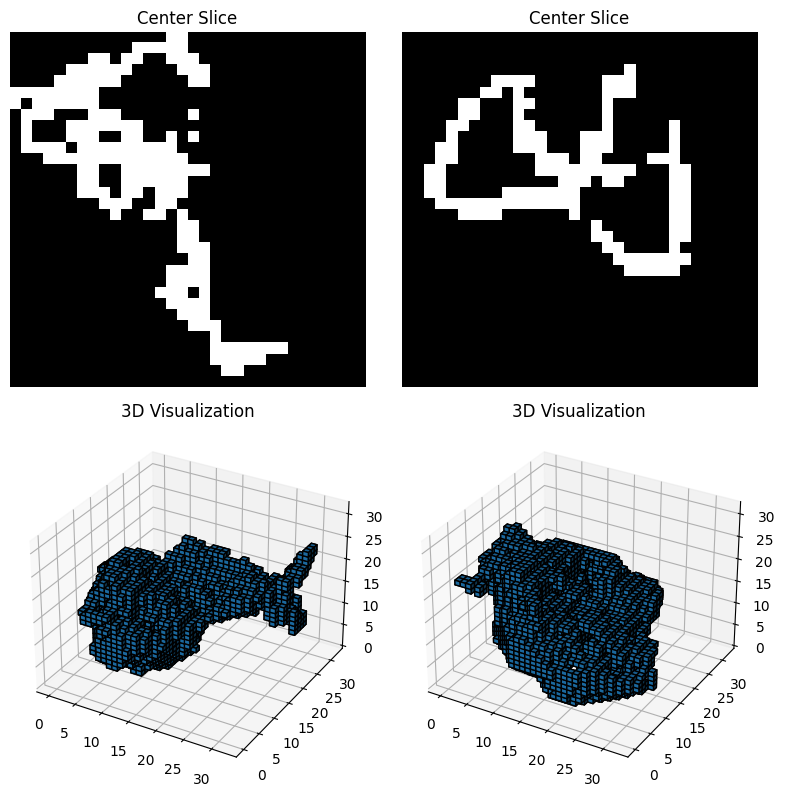

In [37]:
inferencer.visualize_samples(samples)